In [1]:
from multiprocessing import Pool

import copy
import os
import yaml
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import pypsa
import SALib
from SALib.analyze import pawn

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.io import shapereader
import searoute as sr


In [2]:
MWh_per_tH2 = 33
cm = 1 / 2.54

configs = ["scenario_A", "scenario_B", "scenario_C"]

param_sweep_hashes = {
    "scenario_A": "fcbf8015",
    "scenario_B": "fcbf8015",
    "scenario_C": "52b65ce5",
}

# Blue, green, dark green
config_colours = {
    "scenario_A": "#1f77b4",
    "scenario_B": "#2ca02c",
    "scenario_C": "#006400",
}

with open("../config/config.default.yaml", "r") as f:
    default_config = yaml.safe_load(f)

config_dicts = {}
for config in configs:
    with open(f"../results/{config}/config.yaml", "r") as f:
        config_dicts[config] = yaml.safe_load(f)

In [3]:
def load_net(f):
    return f, pypsa.Network(f)


nets = {}
for config in configs:
    # Collect all files in nets_dir ending with .nc
    nets_dir = f"../results/{config}/param_sweeps/{param_sweep_hashes[config]}"
    net_files = [f for f in os.listdir(nets_dir) if f.endswith(".nc")]

    # Load networks in parallel, use map_async
    nets[config] = {}
    with Pool(20) as pool:
        for net_file, net in pool.map_async(
            load_net, [os.path.join(nets_dir, f) for f in net_files]
        ).get():
            nets[config][net_file] = net

INFO:pypsa.io:Imported network elec_s_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.5-EXPORT2-H2 exports+c0.9-H2 exports+m0.9-H2 exports+f1.0-H2 Electrolysis+c0.9-SMR CC+c1.1-co2 stored+c0.9-onwind+c0.8-offwindfixed+c1.2-offwindfloat+c1.0_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.5-EXPORT2-H2 exports+c1.1-H2 exports+m0.8-H2 exports+f0.9-H2 Electrolysis+c0.8-SMR CC+c0.9-co2 stored+c0.9-onwind+c1.0-offwindfixed+c0.7-offwindfloat+c1.0_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.5-EXPORT2-H2 exports+c0.8-H2 exports+m1.0-H2 exports+f1.0-H2 Electrolysis+c1.2-SMR CC+c1.0-co2 stored+c1.0-onwind+c1.2-offwindfixed+c1.3-offwindfloat+c0.8_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:py

In [109]:
# Create a dataframe with multiindex (config, net_file)
idx = pd.MultiIndex.from_tuples(
    [(config, net_file) for config in configs for net_file in nets[config].keys()],
)
stats = pd.DataFrame(columns=["H2 cost", "onwind", "offwind", "solar"], index=idx)
for config in configs:
    n = list(nets[config].values())[0]
    buses_NO = n.buses.loc[(n.buses.carrier == "AC") & (n.buses.country == "NO")].index
    buses_NO_H2 = n.buses.loc[
        (n.buses.carrier == "H2") & (n.buses.location.map(n.buses.country) == "NO")
    ].index
    for net_file, n in nets[config].items():
        stats.loc[(config, net_file), "H2 cost"] = (
            n.snapshot_weightings.objective
            * n.buses_t.marginal_price[buses_NO_H2].mean(axis=1)
        ).sum() / 8760

        stats.loc[(config, net_file), "H2 cost alt"] = n.global_constraints.loc[
            "H2_export", "mu"
        ]

        stats.loc[(config, net_file), "offwind_subsidy"] = (
            n.global_constraints.loc["NO_offwind_min", "mu"]
            if "NO_offwind_min" in n.global_constraints.index
            else 0
        )

        # Calculate total offwind subsidy (i.e. the subsidy times offwind generation),
        # and divide by H2 exports to find subsidy level per unit of H2 exported
        NO_offwind_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO))
            & (n.generators.carrier.isin(["offwind-dc", "offwind-ac", "offwind-float"]))
        ].index
        stats.loc[(config, net_file), "total_offwind_subsidy"] = (
            stats.loc[(config, net_file), "offwind_subsidy"]
            * (
                n.snapshot_weightings.objective
                * n.generators_t.p[NO_offwind_gens].sum(axis=1)
            ).sum()
        )
        stats.loc[(config, net_file), "offwind_subsidy_per_H2"] = (
            stats.loc[(config, net_file), "offwind_subsidy"]
            * (
                n.snapshot_weightings.objective
                * n.generators_t.p[NO_offwind_gens].sum(axis=1)
            ).sum()
            / (1000 * n.global_constraints.loc["H2_export", "constant"] / MWh_per_tH2)
        )

        stats.loc[(config, net_file), "onwind"] = n.generators.loc[
            (n.generators.bus.isin(buses_NO)) & (n.generators.carrier == "onwind"),
            "p_nom_opt",
        ].sum()

        stats.loc[(config, net_file), "offwind"] = n.generators.loc[
            NO_offwind_gens, "p_nom_opt"
        ].sum()
        stats.loc[(config, net_file), "offwind_prod"] = (
            n.snapshot_weightings.objective
            * n.generators_t.p[NO_offwind_gens].sum(axis=1)
        ).sum()

        NO_solar_gens = n.generators.loc[
            (n.generators.bus.isin(buses_NO)) & (n.generators.carrier == "solar")
        ].index
        stats.loc[(config, net_file), "solar"] = n.generators.loc[
            NO_solar_gens,
            "p_nom_opt",
        ].sum()
        stats.loc[(config, net_file), "solar_prod"] = (
            n.snapshot_weightings.objective
            * n.generators_t.p[NO_solar_gens].sum(axis=1)
        ).sum()

        NO_electrolysis_links = n.links.loc[
            (n.links.carrier == "H2 Electrolysis")
            & (n.links.bus0.map(n.buses.location).map(n.buses.country) == "NO")
        ].index
        stats.loc[(config, net_file), "electrolysis"] = (
            n.links.loc[NO_electrolysis_links, "p_nom_opt"].sum().sum()
        )
        if stats.loc[(config, net_file), "electrolysis"] > 1:
            stats.loc[(config, net_file), "electrolysis CF"] = (
                n.snapshot_weightings.objective
                * n.links_t.p0[NO_electrolysis_links].sum(axis=1)
            ).sum() / (8760 * stats.loc[(config, net_file), "electrolysis"])

        if config == "scenario_A":

            # SMR capacity (GW)
            NO_SMR_links = n.links.loc[
                (n.links.carrier == "SMR CC")
                & (n.links.bus0.map(n.buses.location).map(n.buses.country) == "NO")
            ].index
            stats.loc[(config, net_file), "SMR"] = (
                n.links.loc[NO_SMR_links, "p_nom_opt"].sum().sum()
            )

            # SMR capacity factor
            stats.loc[(config, net_file), "SMR CF"] = (
                n.snapshot_weightings.objective
                * n.links_t.p0[NO_SMR_links].sum(axis=1)
            ).sum() / (8760 * stats.loc[(config, net_file), "SMR"])


# Convert cost of H2 to EUR / MWh to EUR / kg
stats["H2 cost"] = stats["H2 cost"] * MWh_per_tH2 / 1000

/tmp/ipykernel_394038/2373443185.py:100: RuntimeWarning: invalid value encountered in scalar divide
  stats.loc[(config, net_file), "SMR CF"] = (


In [26]:
# Minimum offshore wind production (TWh)
stats.groupby(level=0).min()["offwind_prod"] / 1e6

scenario_A      0.000025
scenario_B      0.000055
scenario_C    143.138744
Name: offwind_prod, dtype: float64

In [50]:
stats.groupby(level=0).mean()

,H2 cost,onwind,offwind,solar,H2 cost alt,offwind_subsidy,total_offwind_subsidy,offwind_subsidy_per_H2,offwind_prod,solar_prod
scenario_A,0.0,7461.374343,2506.901079,905.229651,151.354375,0.000000,0.000000e+00,0.000000,1.125430e+07,8.346695e+05
scenario_B,0.0,17722.139609,26190.249541,20056.074377,215.686985,0.000000,0.000000e+00,0.000000,1.069763e+08,1.733842e+07
scenario_C,0.0,6099.908674,35981.224514,6930.842864,220.957566,8.097185,1.159021e+09,0.579511,1.472136e+08,6.373634e+06


In [48]:
# Square kilometres used by onshore and offshore wind
print("sq km used by onshore wind:")
display(stats.groupby(level=0).mean()["onwind"] / float(config_dicts["scenario_A"]["renewable"]["onwind"]["capacity_per_sqkm"]))

print("95th percentile:")
display(stats["onwind"].astype(float).groupby(level=0).quantile(0.95) / float(config_dicts["scenario_A"]["renewable"]["onwind"]["capacity_per_sqkm"]))

sq km used by onshore wind:


scenario_A    2487.124781
scenario_B     5907.37987
scenario_C    2033.302891
Name: onwind, dtype: object

95th percentile:


scenario_A     3604.981006
scenario_B    18352.029215
scenario_C     3539.063802
Name: onwind, dtype: float64

In [117]:
# Maximum offshore wind capacity available south of Bodø (GW)
n = list(nets["scenario_A"].values())[0]

NO_offwind_gens = n.generators.loc[
    (n.generators.bus.isin(buses_NO))
    & (n.generators.carrier.isin(["offwind", "offwind-ac"]))
    & (n.generators.bus.map(n.buses.y) < 67)
].index

n.generators.loc[NO_offwind_gens, "p_nom_max"].sum() / 1e3

17.724666015625

In [107]:
# Total SMR capacity (GW) in scenario A (average over all nets)
print(f"Total installed SMR in scenario A: {stats.loc['scenario_A', 'SMR'].mean() / 1e3:.1f} GW")

# In output: (times efficiency of 69%)
print(f"Total SMR output in scenario A: {(stats.loc['scenario_A', 'SMR'].mean() * 0.69 / 1e3):.1f} GW")

# Average capacity factor
print(f"Average SMR capacity factor: {stats.loc['scenario_A', 'SMR CF'].mean():.2f}")

# Total cost of SMR (take capital cost of a single SMR CC link in a network from scenario A)
SMR_capital_cost = (
    list(nets["scenario_A"].values())[0].links.loc[
        list(nets["scenario_A"].values())[0].links.carrier == "SMR CC", "capital_cost"
    ].mean()
)
print(f"Total cost of SMR: {stats.loc['scenario_A', 'SMR'].mean() * SMR_capital_cost / 1e9:.1f} bn EUR")


Total installed SMR in scenario A: 18.2 GW
Total SMR output in scenario A: 12.6 GW
Average SMR capacity factor: 1.00
Total cost of SMR: 1.4 bn EUR


In [134]:
# The same as above, but for electrolysis in scenario B
print(f"Total installed electrolysis in scenario B: {stats.loc['scenario_B', 'electrolysis'].mean() / 1e3:.1f} GW")

# In output: (times efficiency of 69%)
print(f"Total electrolysis output in scenario B: {(stats.loc['scenario_B', 'electrolysis'].mean() * 0.68 / 1e3):.1f} GW")

# Average capacity factor
print(f"Average electrolysis capacity factor: {stats.loc['scenario_B', 'electrolysis CF'].mean():.4f}")

# Total cost of electrolysis (take capital cost of a single electrolysis link in a network from scenario B)
electrolysis_capital_cost = (
    list(nets["scenario_B"].values())[0].links.loc[
        list(nets["scenario_B"].values())[0].links.carrier == "H2 Electrolysis", "capital_cost"
    ].mean()
)
print(f"Total cost of electrolysis: {stats.loc['scenario_B', 'electrolysis'].mean() * electrolysis_capital_cost / 1e9:.1f} bn EUR")


Total installed electrolysis in scenario B: 16.6 GW
Total electrolysis output in scenario B: 11.3 GW
Average electrolysis capacity factor: 0.9902
Total cost of electrolysis: 0.6 bn EUR


In [135]:
# The same as above, but for electrolysis in scenario C
print(f"Total installed electrolysis in scenario B: {stats.loc['scenario_C', 'electrolysis'].mean() / 1e3:.1f} GW")

# In output: (times efficiency of 69%)
print(f"Total electrolysis output in scenario B: {(stats.loc['scenario_C', 'electrolysis'].mean() * 0.68 / 1e3):.1f} GW")

# Average capacity factor
print(f"Average electrolysis capacity factor: {stats.loc['scenario_C', 'electrolysis CF'].mean():.4f}")

# Total cost of electrolysis (take capital cost of a single electrolysis link in a network from scenario B)
electrolysis_capital_cost = (
    list(nets["scenario_C"].values())[0].links.loc[
        list(nets["scenario_C"].values())[0].links.carrier == "H2 Electrolysis", "capital_cost"
    ].mean()
)
print(f"Total cost of electrolysis: {stats.loc['scenario_C', 'electrolysis'].mean() * electrolysis_capital_cost / 1e9:.1f} bn EUR")

Total installed electrolysis in scenario B: 16.6 GW
Total electrolysis output in scenario B: 11.3 GW
Average electrolysis capacity factor: 0.9900
Total cost of electrolysis: 0.7 bn EUR


In [133]:
# Amount of CO2 captured by Norwegian SMR (Mt CO2 / yr)
n = list(nets["scenario_A"].values())[0]
smr_links = n.links.loc[(n.links.carrier == "SMR CC") & n.links.bus0.str.startswith("NO")].index
print(f"CO2 to atmosphere: {-(n.links_t['p2'][smr_links].sum(axis=1) * n.snapshot_weightings.objective).sum() / 1e6:.2f} Mt")
print(f"CO2 to captured: {-(n.links_t['p3'][smr_links].sum(axis=1) * n.snapshot_weightings.objective).sum() / 1e6:.2f} Mt")

CO2 to atmosphere: 5.78 Mt
CO2 to captured: 51.98 Mt


In [113]:
n.links.loc[n.links.carrier == "H2 Electrolysis", "efficiency"].mean()

0.6796875

In [90]:
n.links.loc[n.links.carrier == "SMR CC"].efficiency

Link
DE0 0 SMR CC-2030     0.69043
DK0 0 SMR CC-2030     0.69043
DK2 0 SMR CC-2030     0.69043
GB1 0 SMR CC-2030     0.69043
GB3 0 SMR CC-2030     0.69043
NL0 0 SMR CC-2030     0.69043
NO2 0 SMR CC-2030     0.69043
NO2 1 SMR CC-2030     0.69043
NO2 10 SMR CC-2030    0.69043
NO2 2 SMR CC-2030     0.69043
NO2 3 SMR CC-2030     0.69043
NO2 4 SMR CC-2030     0.69043
NO2 5 SMR CC-2030     0.69043
NO2 6 SMR CC-2030     0.69043
NO2 7 SMR CC-2030     0.69043
NO2 8 SMR CC-2030     0.69043
NO2 9 SMR CC-2030     0.69043
SE2 0 SMR CC-2030     0.69043
SE2 1 SMR CC-2030     0.69043
SE2 2 SMR CC-2030     0.69043
Name: efficiency, dtype: float64

/tmp/ipykernel_394038/3739919797.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=8)
/tmp/ipykernel_394038/3739919797.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=8)
/tmp/ipykernel_394038/3739919797.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=8)


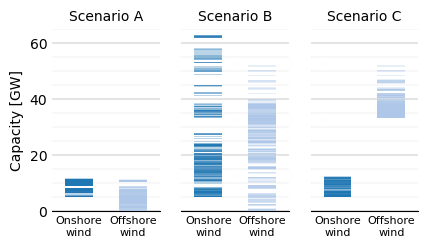

In [5]:
# Stripplots, one for each column of stats, each showing all configs
fig, axs = plt.subplots(1, 3, figsize=(12 * cm, 6 * cm), sharey=True)

# Draw simple wide rectangle as matplotlib path to use as marker in stripplot
marker = mpl.path.Path(
    [
        (-10, -0.5),
        (10, -0.5),
        (10, 0.5),
        (-10, 0.5),
        (-10, -0.5),
    ]
)

for ax, config in zip(axs.flatten(), configs):
    # Plot strip plot of onwind and offwind in the given config, one for each
    sns.stripplot(
        data=stats.loc[config][["onwind", "offwind"]] / 1000,
        # Dark blue, light blue hue
        palette=["#1f77b4", "#aec7e8"],
        marker=marker,
        size=20,
        jitter=0,
        alpha=0.3,
        ax=ax,
    )

    ax.set_ylim(0, 65)

    # Major and minor y grid
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
    ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")
    ax.set_axisbelow(True)

    # Turn off tick marks
    ax.tick_params(axis="both", which="both", length=0)

    # Turn of all but bottom spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set plot title, locate below plot
    ax.set_title(f"Scenario {config[-1]}", fontsize=10)

    # Capitalise x tick labels rotate 20 degrees
    ax.set_xticklabels(["Onshore\nwind", "Offshore\nwind"], fontsize=8)

# Shared y label
axs[0].set_ylabel("Capacity [GW]")

fig.savefig("figures/onwind_offwind.png", bbox_inches="tight", dpi=300)

/tmp/ipykernel_394038/2698417377.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Scenario A", "Scenario B", "Scenario C"])


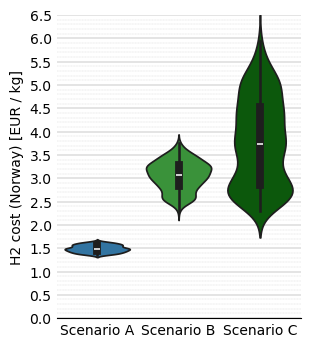

In [6]:
stats["H2 cost total"] = stats["H2 cost"] + stats["offwind_subsidy_per_H2"]

fig, ax = plt.subplots(1, 1, figsize=(8 * cm, 10 * cm))
sns.violinplot(
    data=stats.reset_index(),
    x="level_0",
    y="H2 cost total",
    hue="level_0",
    palette=config_colours,
    # marker=marker,
    # size=30,
    # jitter=0,
    # alpha=0.1,
    ax=ax,
)
ax.set_ylim(0, 6.5)

ax.set_ylabel("H2 cost (Norway) [EUR / kg]")
ax.set_xlabel("")

# Major and minor y grid (first set minor ticks at 0.1)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")
ax.set_axisbelow(True)

# Turn off tick marks
ax.tick_params(axis="both", which="both", length=0)

# Turn of all but bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Give x tick labels prettier names
ax.set_xticklabels(["Scenario A", "Scenario B", "Scenario C"])

fig.savefig("figures/H2_cost.png", bbox_inches="tight", dpi=300)

In [20]:
# Print mean as well as 5th and 95th percentile
for config in configs:
    print(
        f"Scenario {config[-1]}: {stats.loc[config]['H2 cost total'].median():.2f} "
        f"({stats.loc[config]['H2 cost total'].quantile(0.05):.2f} - "
        f"{stats.loc[config]['H2 cost total'].quantile(0.95):.2f})"
    )

Scenario A: 1.49 (1.37 - 1.62)
Scenario B: 3.08 (2.53 - 3.53)
Scenario C: 3.74 (2.53 - 5.27)


In [8]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]

/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('fac

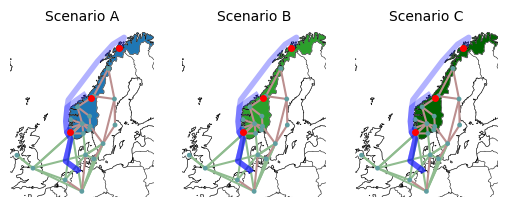

In [136]:
proj = ccrs.LambertConformal(central_longitude=15, central_latitude=65)
boundaries = [-6, 25, 50, 71]

# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(16 * cm, 13 * cm),
    subplot_kw={
        "projection": proj
    },
)

for ax, config in zip(axs.flatten(), configs):
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", color="grey", linewidth=0.5)
    # ax.add_feature(ccrs.cartopy.feature.LAND, color="lightgrey")
    # ax.add_feature(ccrs.cartopy.feature.OCEAN, color="lightgrey")

    # Highlight Norway (but only the country Norway) in light grey
    ax.add_feature(
        ccrs.cartopy.feature.BORDERS,
        edgecolor="lightgrey",
        facecolor="none",
        linewidth=0.5,
    )

    # Plot Norway in light grey
    shapename = "admin_0_countries"
    countries_shp = shapereader.natural_earth(
        resolution="50m", category="cultural", name=shapename
    )
    countries = shapereader.Reader(countries_shp).records()
    norway = [
        country for country in countries if country.attributes["NAME"] == "Norway"
    ][0]
    ax.add_geometries(
        [norway.geometry],
        ccrs.PlateCarree(),
        facecolor=config_colours[config],
        edgecolor="none",
        zorder=1,
    )

    # Plot searoute from Bremerhaven to Stavanger
    bremerhaven = (8.5, 53.5)
    stavanger = (5.7, 58.9)
    trondheim = (10.37, 63.44)
    tromso = (18.9, 69.6)
    routes = [sr.searoute(bremerhaven, c) for c in [stavanger, trondheim, tromso]]
    routes = gpd.GeoDataFrame.from_features(routes)
    routes.plot(
        ax=ax,
        color="blue",
        linewidth=4,
        zorder=10,
        alpha=0.3,
        transform=ccrs.PlateCarree(),
    )

    # Mark each location in Norway with a red dot
    for p in [stavanger, trondheim, tromso]:
        ax.plot(
            p[0],
            p[1],
            "o",
            color="red",
            markersize=4,
            transform=ccrs.PlateCarree(),
            zorder=10,
        )

    # Plot buses with location
    n = list(nets[config].values())[0]
    assign_location(n)
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    n.plot(ax=ax, bus_sizes=0.2, color_geomap=None, boundaries=boundaries)

    ax.set_title(f"Scenario {config[-1]}", fontsize=10)

plt.savefig("figures/map.png", bbox_inches="tight", dpi=300)
plt.savefig("figures/map.pdf", bbox_inches="tight")

/tmp/ipykernel_394038/2789385442.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("figures/map_costs.png", bbox_inches="tight", dpi=300)
/tmp/ipykernel_394038/2789385442.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


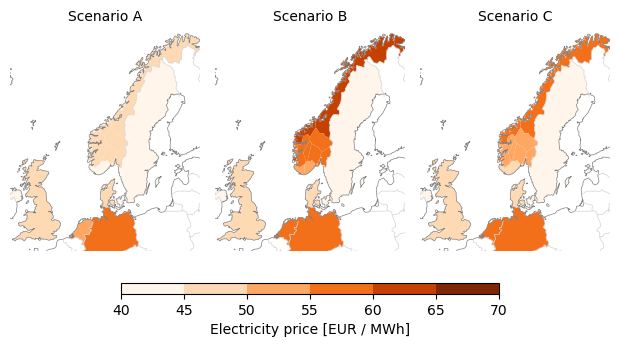

In [10]:
# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(16 * cm, 13 * cm),
    subplot_kw={"projection": proj},
    layout="tight",
)

# Discrete norm with steps of 10, from 50 to 150
cmap = mpl.cm.get_cmap("Oranges")
norm = mpl.colors.BoundaryNorm(np.arange(40, 75, 5), cmap.N)

for ax, config in zip(axs.flatten(), configs):
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", color="grey", linewidth=0.5)

    ax.add_feature(
        ccrs.cartopy.feature.BORDERS,
        edgecolor="lightgrey",
        facecolor="none",
        linewidth=0.5,
    )

    # Load regions of network as geojson
    regions = gpd.read_file(f"../resources/{config}/regions_onshore_elec_s_20.geojson")

    # Find mean electricity price in each region, across all nets
    elec_prices = [
        n.snapshot_weightings.objective
        @ n.buses_t.marginal_price[regions["name"]]
        / 8760
        for n in nets[config].values()
    ]
    regions["price"] = np.mean(elec_prices, axis=0)

    # Plot regions with mean electricity price
    proj4 = proj.proj4_init
    regions = regions.to_crs(proj4)
    regions.plot(
        ax=ax,
        column="price",
        cmap=cmap,
        norm=norm,
        # zorder=20,
        legend=False,
    )

    # Plot buses with location
    # assign_location(n)
    # n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    # n.plot(ax=ax, bus_sizes=0.2, color_geomap=None, boundaries=boundaries)

    # Turn of all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(f"Scenario {config[-1]}", fontsize=10)

# Joint colorbar for all subplots, located below
cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cb = mpl.colorbar.ColorbarBase(
    cax,
    cmap=cmap,
    norm=norm,
    orientation="horizontal",
    label="Electricity price [EUR / MWh]",
)

plt.savefig("figures/map_costs.png", bbox_inches="tight", dpi=300)
fig.tight_layout()
plt.show()

In [11]:
MW_per_pt = 500

onshore_caps = {}
offshore_caps = {}
for config in configs:
    onwind = (
        pd.concat(
            [
                n.generators.loc[n.generators.carrier == "onwind"]
                .groupby("bus")
                .sum()[["p_nom_opt"]]
                / MW_per_pt
                for n in nets[config].values()
            ]
        )
        .groupby(level=0)
        .mean()
    )
    solar = (
        pd.concat(
            [
                n.generators.loc[n.generators.carrier == "solar"]
                .groupby("bus")
                .sum()[["p_nom_opt"]]
                / MW_per_pt
                for n in nets[config].values()
            ]
        )
        .groupby(level=0)
        .mean()
    )
    df = pd.concat([onwind, solar], axis=1)
    onshore_caps[config] = df.loc[df.index.str.contains("NO")]

    offshore_regions = gpd.read_file(
        f"../resources/{config}/regions_offshore_elec_s_20.geojson"
    )
    offshore_regions.set_index("name", inplace=True)
    offshore_caps[config] = [
        np.mean(
            [
                n.generators.loc[
                    (
                        n.generators.carrier.isin(
                            ["offwind-dc", "offwind-ac", "offwind-float"]
                        )
                    )
                    & (n.generators.bus == b),
                    "p_nom_opt",
                ].sum()
                / MW_per_pt
                for n in nets[config].values()
            ]
        )
        for b in offshore_regions.index
    ]

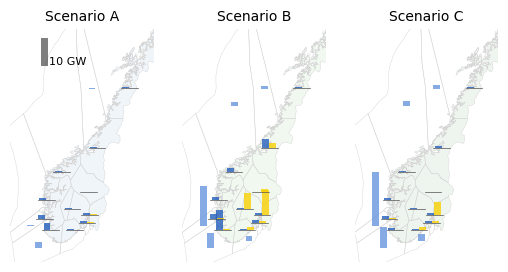

In [12]:
n = list(nets["scenario_A"].values())[0]

# Cartopy map of Norway, projection centered on Norway
fig, axs = plt.subplots(
    1,
    3,
    figsize=(16 * cm, 13 * cm),
    subplot_kw={
        "projection": ccrs.LambertConformal(central_longitude=15, central_latitude=65)
    },
)
boundaries = [2, 18, 57, 70]
for ax, config in zip(axs.flatten(), configs):
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())

    # Shade Norway
    shapename = "admin_0_countries"
    countries_shp = shapereader.natural_earth(
        resolution="50m", category="cultural", name=shapename
    )
    countries = shapereader.Reader(countries_shp).records()
    norway = [
        country for country in countries if country.attributes["NAME"] == "Norway"
    ][0]
    ax.add_geometries(
        [norway.geometry],
        ccrs.PlateCarree(),
        facecolor=config_colours[config] + "11",
        edgecolor="none",
        zorder=1,
    )

    # When plotting things on the map, we need to transform from the coordinate
    # system used by the PyPSA network to the current map projection.
    transform = pypsa.plot.get_projection_from_crs(n.srid)
    x, y = n.buses.x, n.buses.y
    x, y, _ = proj.transform_points(transform, x, y).T
    x = pd.Series(x, index=n.buses.index)
    y = pd.Series(y, index=n.buses.index)

    length = fig.bbox_inches.width * ax.get_position().width
    value_range = np.diff(ax.get_xlim())[0]
    pt = value_range / (length * 72)

    bar_width = 5

    # Plot one bar for each node: onshore wind investment
    df = onshore_caps[config]

    colours = [
        config_dicts[config]["plotting"]["tech_colors"]["onwind"],
        config_dicts[config]["plotting"]["tech_colors"]["solar"],
    ]

    for b in df.index:
        # Plot base line
        bx, by = x.loc[b], y.loc[b]
        ax.plot(
            [
                bx - bar_width * (len(df.columns) / 2 + 0.2) * pt,
                bx + bar_width * (len(df.columns) / 2 + 0.2) * pt,
            ],
            [by, by],
            linewidth=0.5,
            color="#505050",
            zorder=10,
        )
        # Plot investment bars
        for i, d in enumerate(df.loc[b]):
            ax.add_patch(
                mpl.patches.Rectangle(
                    xy=(bx + bar_width * (-len(df.columns) / 2 + i) * pt, by),
                    width=bar_width * pt,
                    height=d * pt,
                    facecolor=colours[i],
                    zorder=9,
                    alpha=0.8,
                )
            )

    offshore_regions = gpd.read_file(
        f"../resources/{config}/regions_offshore_elec_s_20.geojson"
    )
    offshore_regions.set_index("name", inplace=True)
    proj4 = proj.proj4_init
    offshore_regions = offshore_regions.to_crs(proj4)
    offshore_regions["offwind"] = offshore_caps[config]

    # Restrict to offshore regions in Norway
    offshore_regions = offshore_regions.loc[offshore_regions.index.str.contains("NO")]

    # Plot boundaries of offshore regions
    offshore_regions.plot(
        ax=ax,
        facecolor="none",
        edgecolor="lightgrey",
        linewidth=0.3,
        zorder=1,
    )

    # Get x and y centroids of offshore regions
    off_x = offshore_regions.geometry.centroid.x
    off_y = offshore_regions.geometry.centroid.y
    # off_x, off_y, _ = proj.transform_points(transform, off_x, off_y).T
    off_x = pd.Series(off_x, index=offshore_regions.index)
    off_y = pd.Series(off_y, index=offshore_regions.index)

    for b in offshore_regions.index:
        # Plot base line
        bx, by = off_x.loc[b], off_y.loc[b]
        # Plot investment bars
        ax.add_patch(
            mpl.patches.Rectangle(
                xy=(bx, by),
                width=bar_width * pt,
                height=offshore_regions.loc[b, "offwind"] * pt,
                facecolor=config_dicts[config]["plotting"]["tech_colors"]["offwind"],
                zorder=10,
                alpha=0.8,
            )
        )

    onshore_regions = gpd.read_file(
        f"../resources/{config}/regions_onshore_elec_s_20.geojson"
    )
    onshore_regions.set_index("name", inplace=True)
    onshore_regions = onshore_regions.to_crs(proj4)

    # Restrict to offshore regions in Norway
    onshore_regions = onshore_regions.loc[onshore_regions.index.str.contains("NO")]

    # Plot boundaries of offshore regions
    onshore_regions.plot(
        ax=ax,
        facecolor="none",
        edgecolor="lightgrey",
        linewidth=0.3,
        zorder=1,
    )

    ax.set_title(f"Scenario {config[-1]}", fontsize=10)

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].add_patch(
    mpl.patches.Rectangle(
        xy=proj.transform_point(2.5, 68, ccrs.PlateCarree()),
        width=bar_width * pt,
        height=(10000 / MW_per_pt) * pt,
        facecolor="black",
        zorder=10,
        alpha=0.5,
    )
)
axs[0].annotate(
    xy=(2.5, 68), #proj.transform_point(2.5, 68, ccrs.PlateCarree()),
    xycoords=ccrs.PlateCarree(),
    textcoords="offset points",
    xytext=(bar_width + 1, 1),
    text="10 GW",
    fontsize=8,
)

plt.savefig("figures/map_wind.png", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
# Use salib to analyse sensitivity of H2 cost to input parameters
stats["H2 cost total"] = stats["H2 cost"] + stats["offwind_subsidy_per_H2"]
sa_stats = stats[["H2 cost total"]]
params = list(set([p for c in config_dicts.values() for p in c["param_sweep"]]))
for config in configs:
    param_config = config_dicts[config]["param_sweep"]
    for f in sa_stats.loc[config].index:
        n = nets[config][f]
        for p in params:
            carrier = param_config[p]["carrier"]
            attr = param_config[p]["attr"]

            # Find the factor for this parameters in the file name f, which is of the form <carrier>+<attr><factor>. The factor is a float. Use regex.
            m = re.search(f"{carrier}\+{attr}(\d+\.\d+)", f)
            if m is None:
                factor = 1
            else:
                factor = float(m.group(1))
            sa_stats.loc[(config, f), p] = factor

/tmp/ipykernel_394038/908076975.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_stats.loc[(config, f), p] = factor
/tmp/ipykernel_394038/908076975.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_stats.loc[(config, f), p] = factor
/tmp/ipykernel_394038/908076975.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

R^2 for scenario_A: 0.9993232327971203
R^2 for scenario_B: 0.9369598585900129
R^2 for scenario_C: 0.9551941792399603


/tmp/ipykernel_394038/1913795328.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


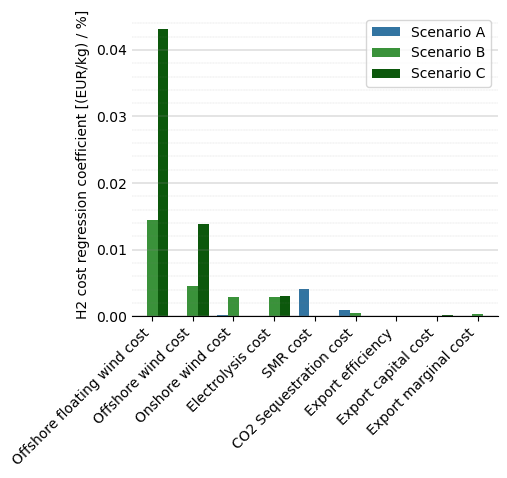

In [14]:
# Perform linear regression of H2 cost on input parameters
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
lrs = {}
for config in configs:
    X = sa_stats.loc[config][params].values
    Y = sa_stats.loc[config]["H2 cost total"].values
    lrs[config] = LinearRegression().fit(X, Y)
    print(f"R^2 for {config}: {lrs[config].score(X, Y)}")

# Plot bar plot of coefficients as above
df = pd.concat(
    [
        pd.Series(lrs[config].coef_, index=params, name=config)
        for config in configs
    ],
    axis=1,
)

# Sort index by average coefficient
df = df.loc[df.abs().sum(axis=1).sort_values(ascending=False).index]
labels = df.index

df = df.reset_index().melt(id_vars="index", var_name="config", value_name="coef")
df["coef"] /= 100 # Convert to %
sns.barplot(
    data=df,
    x="index",
    y="coef",
    hue="config",
    ax=ax,
    palette=config_colours,
)

ax.set_ylabel("H2 cost regression coefficient [(EUR/kg) / %]")
ax.set_xlabel("")

# Rotate x ticks
# Params:
pretty_param_names = {
    "export_efficiency": "Export efficiency",
    "electrolysis_cost": "Electrolysis cost",
    "onwind_cost": "Onshore wind cost",
    "SMR_cost": "SMR cost",
    "offwind-ac_cost": "Offshore wind cost",
    "export_capital_cost": "Export capital cost",
    "export_marginal_cost": "Export marginal cost",
    "offwind-float_cost": "Offshore floating wind cost",
    "sequestration_cost": "CO2 Sequestration cost",
}
ax.set_xticklabels(
    [pretty_param_names[p] for p in labels],
    rotation=45,
    ha="right",
)

ax.set_ylim(bottom=0)

# Format legend labels
handles, labels = ax.get_legend_handles_labels()
labels = [f"Scenario {l[-1]}" for l in labels]
ax.legend(handles, labels)

# Remove legend title
ax.get_legend().set_title("")

# Turn off all but bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Auto location of minor ticks
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

# Turn on major and minor grid lines
ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.3, color="grey")
ax.yaxis.grid(True, which="minor", linestyle=":", linewidth=0.2, color="grey")

# Turn of y tick marks
ax.tick_params(axis="y", which="both", length=0)
    
fig.savefig("figures/sensitivity.png", bbox_inches="tight", dpi=300)
plt.show()

,scenario_A,scenario_B,scenario_C
electrolysis_cost,0.086423,0.148033,0.126853
export_capital_cost,0.086798,0.061140,0.063333
offwind-ac_cost,0.113544,0.162892,0.164378
onwind_cost,0.100485,0.126289,0.101617
export_efficiency,0.097108,0.080022,0.082624
SMR_cost,0.660000,0.083115,0.098036
export_marginal_cost,0.072123,0.076506,0.087308
sequestration_cost,0.123405,0.082586,0.073606
offwind-float_cost,0.101651,0.465000,0.526250


/tmp/ipykernel_394038/2982550438.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


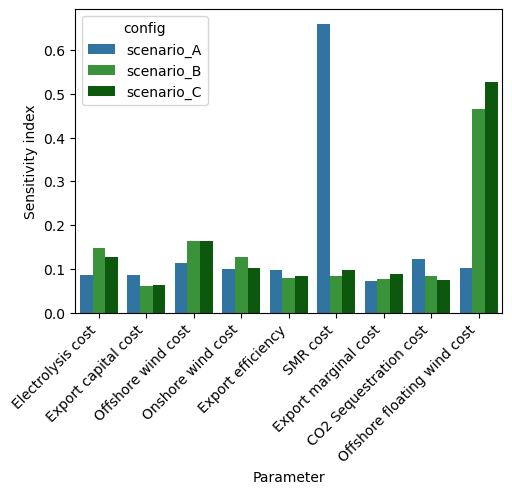

In [15]:
# Use SAlib pawn analysis to analyse sensitivity of H2 cost to input parameters
from SALib.analyze import pawn

method = pawn
key = "median"

Sis = {}
for config, c in config_dicts.items():
    param_config = c["param_sweep"]
    problem = {
        "num_vars": len(params),
        "names": params,
        "bounds": [
            [min(param_config[p]["factors"]), max(param_config[p]["factors"])]
            for p in params
        ],
    }
    X = sa_stats.loc[config][params].values
    Y = sa_stats.loc[config]["H2 cost total"].values
    # Sis[config] = pawm.analyze(problem, X, Y, print_to_console=False)
    Sis[config] = method.analyze(problem, X, Y, print_to_console=False)

# Plot sensitivity indices as bar plots
fig, ax = plt.subplots(1, 1, figsize=(14 * cm, 10 * cm))
df = pd.concat(
    [pd.Series(Sis[config][key], index=params, name=config) for config in configs],
    axis=1,
)
display(df)
df = df.reset_index().melt(id_vars="index", var_name="config", value_name="S1")
sns.barplot(
    data=df,
    x="index",
    y="S1",
    hue="config",
    ax=ax,
    palette=config_colours,
)

ax.set_ylabel("Sensitivity index")
ax.set_xlabel("Parameter")

# Rotate x ticks
ax.set_xticklabels(
    [pretty_param_names[p] for p in params],
    rotation=45,
    ha="right",
)

plt.show()

In [16]:
def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "H2 Electrolysis": "hydrogen",
        "H2 Fuel Cell": "hydrogen",
        "H2 pipeline": "hydrogen",
        "battery": "battery storage",
        "CC": "CCS",
    }

    rename = {
        "solar rooftop": "solar",
        "Sabatier": "hydrogen",
        "Fischer-Tropsch": "hydrogen",
        "H2": "hydrogen",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind",
        "offwind-dc": "offshore wind",
        "onwind": "onshore wind",
        "ror": "hydro",
        "hydro": "hydro",
        "PHS": "hydro",
        "co2 Store": "DAC",
        "co2 stored": "CCS",
        "AC": "transmission",
        "DC": "transmission",
        "B2B": "transmission",
        "air heat pump": "electric heating",
        "ground heat pump": "electric heating",
        "resistive heater": "electric heating",
        "uranium": "nuclear",
        "solid biomass transport": "biomass,biogas",
        "solid biomass": "biomass,biogas",
        "biogas": "biomass,biogas",
        "gas": "gas,heating,CHP",
        "CHP": "gas,heating,CHP",
        "OCGT": "gas,heating,CHP",
        "gas boiler": "gas,heating,CHP",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


preferred_order = pd.Index(
    [
        "solar",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "hydrogen",
        "transmission",
        "electricity distribution grid",
        "nuclear",
        "hydro",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "electric heating",
        "gas,heating,CHP",
        "solid biomass",
        "biogas",
        "biomass,biogas",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "electric heating",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

# Load yaml config
plot_config = config_dicts["scenario_A"]["plotting"]
plot_config["tech_colors"]["transmission"] = plot_config["tech_colors"]["transmission lines"]
plot_config["tech_colors"]["carbon capture"] = plot_config["tech_colors"]["CC"]
plot_config["tech_colors"]["hydrogen"] = plot_config["tech_colors"]["hydrogen storage"]
plot_config["tech_colors"]["electric heating"] = plot_config["tech_colors"]["heat pump"]
plot_config["tech_colors"]["marginal costs"] = "#909090"
plot_config["tech_colors"]["biomass,biogas"] = plot_config["tech_colors"]["solid biomass"]
plot_config["tech_colors"]["gas,heating,CHP"] = plot_config["tech_colors"]["gas"]

opt_name = {
    "Store": "e",
    "Line": "s",
    "Transformer": "s"
}

def calculate_costs(n, label, costs):

    for c in n.iterate_components(n.branch_components|n.controllable_one_port_components^{"Load"}):
        capital_costs = c.df.capital_cost*c.df[opt_name.get(c.name,"p") + "_nom_opt"]
        capital_costs_grouped = capital_costs.groupby(c.df.carrier).sum()

        capital_costs_grouped = pd.concat([capital_costs_grouped], keys=["capital"])
        capital_costs_grouped = pd.concat([capital_costs_grouped], keys=[c.list_name])

        costs = costs.reindex(capital_costs_grouped.index.union(costs.index))

        costs.loc[capital_costs_grouped.index, label] = capital_costs_grouped

        if c.name == "Link":
            p = c.pnl.p0.multiply(n.snapshot_weightings.generators, axis=0).sum()
        elif c.name == "Line":
            continue
        elif c.name == "StorageUnit":
            p_all = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0)
            p_all[p_all < 0.] = 0.
            p = p_all.sum()
        else:
            p = c.pnl.p.multiply(n.snapshot_weightings.generators, axis=0).sum()

        #correct sequestration cost
        if c.name == "Store":
            items = c.df.index[(c.df.carrier == "co2 stored") & (c.df.marginal_cost <= -100.)]
            c.df.loc[items, "marginal_cost"] = -20.

        marginal_costs = p*c.df.marginal_cost

        marginal_costs_grouped = marginal_costs.groupby(c.df.carrier).sum()

        marginal_costs_grouped = pd.concat([marginal_costs_grouped], keys=["marginal"])
        marginal_costs_grouped = pd.concat([marginal_costs_grouped], keys=[c.list_name])

        costs = costs.reindex(marginal_costs_grouped.index.union(costs.index))

        costs.loc[marginal_costs_grouped.index,label] = marginal_costs_grouped

    return costs

In [17]:
config = "scenario_B"

cost_df = pd.DataFrame()

for f, n in nets[config].items():
    cost_df = calculate_costs(n, f, cost_df)

df = cost_df.groupby(cost_df.index.get_level_values(2)).sum()
df = df / 1e9
df = df.groupby(df.index.map(rename_techs)).sum()
to_drop = df.index[df.max(axis=1) < plot_config['costs_threshold']]
df = df.drop(to_drop)
new_index = preferred_order.intersection(df.index).append(df.index.difference(preferred_order))
new_columns = df.sum().sort_values().index
df = df.loc[new_index, new_columns]

/tmp/ipykernel_394038/3315168679.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df.index)


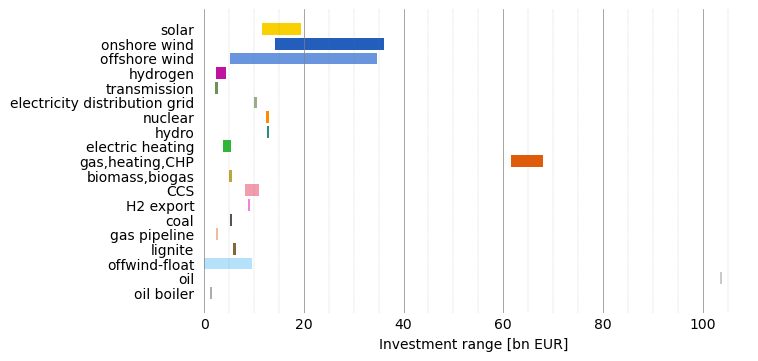

In [18]:
# Plot bars indicating the maximum and minimum cost for each row of df
fig, ax = plt.subplots(figsize=(18 * cm, 10 * cm))
ax.barh(
    y=df.index,
    width=(df.max(axis=1) - df.min(axis=1)).clip(0.5, None),
    left=df.min(axis=1),
    color=[plot_config["tech_colors"][c] for c in df.index],
)

# Flip the y-axis so that the largest cost is at the top
ax.invert_yaxis()

# Set lower x axis limit to 0
ax.set_xlim(left=-1)

# Set font size for labels and ticks
ax.tick_params(axis="both", which="major")
ax.set_yticklabels(df.index)

# Turn off tick marks
ax.tick_params(axis="both", which="both", length=0)

# Turn off all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Major and minor x grid at multiples of 100 and 20
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.grid(
    which="major", axis="x", linestyle="-", linewidth="0.5", color="grey", zorder=0
)
ax.grid(
    which="minor", axis="x", linestyle=":", linewidth="0.25", color="grey", zorder=0
)


# x axis label
ax.set_xlabel("Investment range [bn EUR]")

# plt.savefig(f"figures/total-costs-{config_name}.pdf", bbox_inches="tight")
plt.show()